# Autoencoder Lines

Let's use an autoencoder for the Lines dataset. 

The first experiment imports the 2D data points and casts them into a 1D vector. The (x,y) coordinates are mapped into successive inputs. They are hence correlated... This apparently is tremendously difficult to reconstruct for the autoencoder. Why? In the end it is just a difference between input and output. 

In [1]:
from keras.datasets import mnist
import numpy as np
import h5py
#from matplotlib.mlab import griddata
from scipy.interpolate import griddata

filename = '/home/anne/data/h5/lines.h5'
f = h5py.File(filename, 'r')
#for key in f.keys():
#    print(key)
data = np.array(f["data"])

def pnts2grid(x, y, resX=28, resY=28):
    xrange = np.linspace(0, resX - 1, 1)
    yrange = np.linspace(0, resY - 1, 1)
    Z = np.zeros((resX, resY))
    for i in range(len(x)):
        xpixel = round((x[i] - min(x)) / (max(x) - min(x)) * resX - 1).astype('int')
        ypixel = round((y[i] - min(y)) / (max(y) - min(y)) * resY - 1).astype('int')
        Z[xpixel,ypixel] = 1
    return Z

# Training and test set are 2D points
N = 100
resX = resY = 28
z = np.zeros((N, resX, resY))
for i in range(N):
    x = data[i,:,0]
    y = data[i,:,1]
    z[i,:,:] = pnts2grid(x, y, resX, resY)

x_train = z[0:80]
x_test  = z[80:N]

# Print one particular input to check if the discretization to a 28x28 grid went okay
zfig=x_train[1]
import matplotlib.pyplot as plt
plt.imshow(zfig, interpolation='nearest', cmap='Blues',
    extent=(0.5,np.shape(zfig)[0]+0.5,0.5,np.shape(zfig)[1]+0.5))
plt.colorbar()
plt.show()
    
# Make them into 32-bit floats
#x_train = x_train.astype('float32') / 255.
#x_test = x_test.astype('float32') / 255.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32') 

# Create 1-dimensional vector of input, the coordinates are just fed into subsequent input nodes
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

input_size = x_train.shape[1]

Using TensorFlow backend.


<Figure size 640x480 with 2 Axes>

(80, 784)
(20, 784)


In [2]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations 
encoding_dim = 32
batch_size = 100
epochs = 1000

# this is our input placeholder
input_img = Input(shape=(input_size,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_size, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [3]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [4]:
# types of optimizers:
#  adam
#  adagrad
#  sgd
# types of losses:
# - mean_absolute_error (gets all zeros)
# - hinge, squared_hinge
# - logcosh
# - kullback_leibler_divergence (gest all ones)
# - binary_crossentropy (adam/adagrad gets somewhere)
# - poisson (as well)
# - cosine_proximity (vague)
# - mean_squared_logarithmic_error
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [5]:
# the autoencoder should learn to map the x_train input data to x_train as output
autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=False,
                validation_data=(x_test, x_test))

Train on 80 samples, validate on 20 samples
Epoch 1/1000
80/80 [==============================] - 0s 2ms/step - loss: 0.6956 - val_loss: 0.6927
Epoch 2/1000
80/80 [==============================] - 0s 113us/step - loss: 0.6922 - val_loss: 0.6894
Epoch 3/1000
80/80 [==============================] - 0s 112us/step - loss: 0.6890 - val_loss: 0.6860
Epoch 4/1000
80/80 [==============================] - 0s 119us/step - loss: 0.6856 - val_loss: 0.6821
Epoch 5/1000
80/80 [==============================] - 0s 108us/step - loss: 0.6818 - val_loss: 0.6776
Epoch 6/1000
80/80 [==============================] - 0s 101us/step - loss: 0.6773 - val_loss: 0.6723
Epoch 7/1000
80/80 [==============================] - 0s 187us/step - loss: 0.6720 - val_loss: 0.6660
Epoch 8/1000
80/80 [==============================] - 0s 111us/step - loss: 0.6657 - val_loss: 0.6586
Epoch 9/1000
80/80 [==============================] - 0s 161us/step - loss: 0.6583 - val_loss: 0.6502
Epoch 10/1000
80/80 [===================

Epoch 81/1000
80/80 [==============================] - 0s 115us/step - loss: 0.2925 - val_loss: 0.3201
Epoch 82/1000
80/80 [==============================] - 0s 100us/step - loss: 0.2921 - val_loss: 0.3201
Epoch 83/1000
80/80 [==============================] - 0s 180us/step - loss: 0.2918 - val_loss: 0.3200
Epoch 84/1000
80/80 [==============================] - 0s 112us/step - loss: 0.2915 - val_loss: 0.3200
Epoch 85/1000
80/80 [==============================] - 0s 93us/step - loss: 0.2912 - val_loss: 0.3200
Epoch 86/1000
80/80 [==============================] - 0s 187us/step - loss: 0.2908 - val_loss: 0.3199
Epoch 87/1000
80/80 [==============================] - 0s 135us/step - loss: 0.2905 - val_loss: 0.3199
Epoch 88/1000
80/80 [==============================] - 0s 95us/step - loss: 0.2902 - val_loss: 0.3198
Epoch 89/1000
80/80 [==============================] - 0s 143us/step - loss: 0.2898 - val_loss: 0.3198
Epoch 90/1000
80/80 [==============================] - 0s 102us/step - loss

80/80 [==============================] - 0s 160us/step - loss: 0.2556 - val_loss: 0.3140
Epoch 161/1000
80/80 [==============================] - 0s 153us/step - loss: 0.2549 - val_loss: 0.3139
Epoch 162/1000
80/80 [==============================] - 0s 153us/step - loss: 0.2542 - val_loss: 0.3138
Epoch 163/1000
80/80 [==============================] - 0s 156us/step - loss: 0.2535 - val_loss: 0.3137
Epoch 164/1000
80/80 [==============================] - 0s 137us/step - loss: 0.2527 - val_loss: 0.3135
Epoch 165/1000
80/80 [==============================] - 0s 243us/step - loss: 0.2520 - val_loss: 0.3134
Epoch 166/1000
80/80 [==============================] - 0s 104us/step - loss: 0.2513 - val_loss: 0.3133
Epoch 167/1000
80/80 [==============================] - 0s 147us/step - loss: 0.2505 - val_loss: 0.3132
Epoch 168/1000
80/80 [==============================] - 0s 118us/step - loss: 0.2498 - val_loss: 0.3131
Epoch 169/1000
80/80 [==============================] - 0s 146us/step - loss: 0

80/80 [==============================] - 0s 150us/step - loss: 0.1879 - val_loss: 0.3068
Epoch 240/1000
80/80 [==============================] - 0s 122us/step - loss: 0.1870 - val_loss: 0.3068
Epoch 241/1000
80/80 [==============================] - 0s 125us/step - loss: 0.1861 - val_loss: 0.3068
Epoch 242/1000
80/80 [==============================] - 0s 155us/step - loss: 0.1853 - val_loss: 0.3068
Epoch 243/1000
80/80 [==============================] - 0s 93us/step - loss: 0.1844 - val_loss: 0.3069
Epoch 244/1000
80/80 [==============================] - 0s 93us/step - loss: 0.1835 - val_loss: 0.3069
Epoch 245/1000
80/80 [==============================] - 0s 124us/step - loss: 0.1826 - val_loss: 0.3069
Epoch 246/1000
80/80 [==============================] - 0s 107us/step - loss: 0.1818 - val_loss: 0.3069
Epoch 247/1000
80/80 [==============================] - 0s 79us/step - loss: 0.1809 - val_loss: 0.3069
Epoch 248/1000
80/80 [==============================] - 0s 103us/step - loss: 0.18

Epoch 318/1000
80/80 [==============================] - 0s 171us/step - loss: 0.1249 - val_loss: 0.3175
Epoch 319/1000
80/80 [==============================] - 0s 164us/step - loss: 0.1242 - val_loss: 0.3178
Epoch 320/1000
80/80 [==============================] - 0s 121us/step - loss: 0.1235 - val_loss: 0.3181
Epoch 321/1000
80/80 [==============================] - 0s 151us/step - loss: 0.1228 - val_loss: 0.3183
Epoch 322/1000
80/80 [==============================] - 0s 130us/step - loss: 0.1221 - val_loss: 0.3186
Epoch 323/1000
80/80 [==============================] - 0s 155us/step - loss: 0.1214 - val_loss: 0.3189
Epoch 324/1000
80/80 [==============================] - 0s 154us/step - loss: 0.1207 - val_loss: 0.3192
Epoch 325/1000
80/80 [==============================] - 0s 123us/step - loss: 0.1200 - val_loss: 0.3195
Epoch 326/1000
80/80 [==============================] - 0s 105us/step - loss: 0.1193 - val_loss: 0.3198
Epoch 327/1000
80/80 [==============================] - 0s 182us

Epoch 397/1000
80/80 [==============================] - 0s 151us/step - loss: 0.0784 - val_loss: 0.3502
Epoch 398/1000
80/80 [==============================] - 0s 116us/step - loss: 0.0779 - val_loss: 0.3508
Epoch 399/1000
80/80 [==============================] - 0s 101us/step - loss: 0.0774 - val_loss: 0.3513
Epoch 400/1000
80/80 [==============================] - 0s 95us/step - loss: 0.0770 - val_loss: 0.3519
Epoch 401/1000
80/80 [==============================] - 0s 159us/step - loss: 0.0765 - val_loss: 0.3524
Epoch 402/1000
80/80 [==============================] - 0s 126us/step - loss: 0.0760 - val_loss: 0.3529
Epoch 403/1000
80/80 [==============================] - 0s 89us/step - loss: 0.0756 - val_loss: 0.3535
Epoch 404/1000
80/80 [==============================] - 0s 100us/step - loss: 0.0751 - val_loss: 0.3540
Epoch 405/1000
80/80 [==============================] - 0s 82us/step - loss: 0.0747 - val_loss: 0.3546
Epoch 406/1000
80/80 [==============================] - 0s 100us/st

Epoch 476/1000
80/80 [==============================] - 0s 150us/step - loss: 0.0487 - val_loss: 0.3984
Epoch 477/1000
80/80 [==============================] - 0s 122us/step - loss: 0.0484 - val_loss: 0.3991
Epoch 478/1000
80/80 [==============================] - 0s 99us/step - loss: 0.0481 - val_loss: 0.3997
Epoch 479/1000
80/80 [==============================] - 0s 99us/step - loss: 0.0478 - val_loss: 0.4004
Epoch 480/1000
80/80 [==============================] - 0s 130us/step - loss: 0.0476 - val_loss: 0.4011
Epoch 481/1000
80/80 [==============================] - 0s 160us/step - loss: 0.0473 - val_loss: 0.4017
Epoch 482/1000
80/80 [==============================] - 0s 160us/step - loss: 0.0470 - val_loss: 0.4024
Epoch 483/1000
80/80 [==============================] - 0s 94us/step - loss: 0.0467 - val_loss: 0.4031
Epoch 484/1000
80/80 [==============================] - 0s 137us/step - loss: 0.0464 - val_loss: 0.4038
Epoch 485/1000
80/80 [==============================] - 0s 143us/st

Epoch 555/1000
80/80 [==============================] - 0s 101us/step - loss: 0.0310 - val_loss: 0.4516
Epoch 556/1000
80/80 [==============================] - 0s 147us/step - loss: 0.0309 - val_loss: 0.4523
Epoch 557/1000
80/80 [==============================] - 0s 101us/step - loss: 0.0307 - val_loss: 0.4530
Epoch 558/1000
80/80 [==============================] - 0s 96us/step - loss: 0.0305 - val_loss: 0.4536
Epoch 559/1000
80/80 [==============================] - 0s 140us/step - loss: 0.0304 - val_loss: 0.4543
Epoch 560/1000
80/80 [==============================] - 0s 173us/step - loss: 0.0302 - val_loss: 0.4550
Epoch 561/1000
80/80 [==============================] - 0s 126us/step - loss: 0.0300 - val_loss: 0.4557
Epoch 562/1000
80/80 [==============================] - 0s 184us/step - loss: 0.0299 - val_loss: 0.4563
Epoch 563/1000
80/80 [==============================] - 0s 112us/step - loss: 0.0297 - val_loss: 0.4570
Epoch 564/1000
80/80 [==============================] - 0s 134us/

Epoch 634/1000
80/80 [==============================] - 0s 103us/step - loss: 0.0206 - val_loss: 0.5031
Epoch 635/1000
80/80 [==============================] - 0s 138us/step - loss: 0.0205 - val_loss: 0.5037
Epoch 636/1000
80/80 [==============================] - 0s 152us/step - loss: 0.0204 - val_loss: 0.5044
Epoch 637/1000
80/80 [==============================] - 0s 168us/step - loss: 0.0203 - val_loss: 0.5050
Epoch 638/1000
80/80 [==============================] - 0s 125us/step - loss: 0.0202 - val_loss: 0.5056
Epoch 639/1000
80/80 [==============================] - 0s 142us/step - loss: 0.0201 - val_loss: 0.5062
Epoch 640/1000
80/80 [==============================] - 0s 138us/step - loss: 0.0200 - val_loss: 0.5069
Epoch 641/1000
80/80 [==============================] - 0s 155us/step - loss: 0.0199 - val_loss: 0.5075
Epoch 642/1000
80/80 [==============================] - 0s 96us/step - loss: 0.0198 - val_loss: 0.5081
Epoch 643/1000
80/80 [==============================] - 0s 89us/s

Epoch 713/1000
80/80 [==============================] - 0s 145us/step - loss: 0.0142 - val_loss: 0.5502
Epoch 714/1000
80/80 [==============================] - 0s 151us/step - loss: 0.0142 - val_loss: 0.5507
Epoch 715/1000
80/80 [==============================] - 0s 148us/step - loss: 0.0141 - val_loss: 0.5513
Epoch 716/1000
80/80 [==============================] - 0s 134us/step - loss: 0.0140 - val_loss: 0.5519
Epoch 717/1000
80/80 [==============================] - 0s 96us/step - loss: 0.0140 - val_loss: 0.5524
Epoch 718/1000
80/80 [==============================] - 0s 136us/step - loss: 0.0139 - val_loss: 0.5530
Epoch 719/1000
80/80 [==============================] - 0s 133us/step - loss: 0.0139 - val_loss: 0.5536
Epoch 720/1000
80/80 [==============================] - 0s 177us/step - loss: 0.0138 - val_loss: 0.5541
Epoch 721/1000
80/80 [==============================] - 0s 169us/step - loss: 0.0137 - val_loss: 0.5547
Epoch 722/1000
80/80 [==============================] - 0s 167us/

Epoch 792/1000
80/80 [==============================] - 0s 170us/step - loss: 0.0102 - val_loss: 0.5922
Epoch 793/1000
80/80 [==============================] - 0s 182us/step - loss: 0.0102 - val_loss: 0.5927
Epoch 794/1000
80/80 [==============================] - 0s 112us/step - loss: 0.0101 - val_loss: 0.5932
Epoch 795/1000
80/80 [==============================] - 0s 90us/step - loss: 0.0101 - val_loss: 0.5937
Epoch 796/1000
80/80 [==============================] - 0s 165us/step - loss: 0.0101 - val_loss: 0.5942
Epoch 797/1000
80/80 [==============================] - 0s 109us/step - loss: 0.0100 - val_loss: 0.5947
Epoch 798/1000
80/80 [==============================] - 0s 137us/step - loss: 0.0100 - val_loss: 0.5952
Epoch 799/1000
80/80 [==============================] - 0s 173us/step - loss: 0.0099 - val_loss: 0.5957
Epoch 800/1000
80/80 [==============================] - 0s 133us/step - loss: 0.0099 - val_loss: 0.5962
Epoch 801/1000
80/80 [==============================] - 0s 153us/

Epoch 871/1000
80/80 [==============================] - 0s 119us/step - loss: 0.0076 - val_loss: 0.6293
Epoch 872/1000
80/80 [==============================] - 0s 82us/step - loss: 0.0076 - val_loss: 0.6297
Epoch 873/1000
80/80 [==============================] - 0s 161us/step - loss: 0.0075 - val_loss: 0.6302
Epoch 874/1000
80/80 [==============================] - 0s 111us/step - loss: 0.0075 - val_loss: 0.6306
Epoch 875/1000
80/80 [==============================] - 0s 88us/step - loss: 0.0075 - val_loss: 0.6311
Epoch 876/1000
80/80 [==============================] - 0s 102us/step - loss: 0.0075 - val_loss: 0.6315
Epoch 877/1000
80/80 [==============================] - 0s 159us/step - loss: 0.0074 - val_loss: 0.6319
Epoch 878/1000
80/80 [==============================] - 0s 172us/step - loss: 0.0074 - val_loss: 0.6324
Epoch 879/1000
80/80 [==============================] - 0s 152us/step - loss: 0.0074 - val_loss: 0.6328
Epoch 880/1000
80/80 [==============================] - 0s 136us/s

Epoch 950/1000
80/80 [==============================] - 0s 88us/step - loss: 0.0058 - val_loss: 0.6622
Epoch 951/1000
80/80 [==============================] - 0s 149us/step - loss: 0.0058 - val_loss: 0.6626
Epoch 952/1000
80/80 [==============================] - 0s 116us/step - loss: 0.0058 - val_loss: 0.6630
Epoch 953/1000
80/80 [==============================] - 0s 105us/step - loss: 0.0058 - val_loss: 0.6634
Epoch 954/1000
80/80 [==============================] - 0s 144us/step - loss: 0.0058 - val_loss: 0.6638
Epoch 955/1000
80/80 [==============================] - 0s 110us/step - loss: 0.0057 - val_loss: 0.6641
Epoch 956/1000
80/80 [==============================] - 0s 191us/step - loss: 0.0057 - val_loss: 0.6645
Epoch 957/1000
80/80 [==============================] - 0s 93us/step - loss: 0.0057 - val_loss: 0.6649
Epoch 958/1000
80/80 [==============================] - 0s 81us/step - loss: 0.0057 - val_loss: 0.6653
Epoch 959/1000
80/80 [==============================] - 0s 170us/st

In [6]:
# encode and decode lines
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

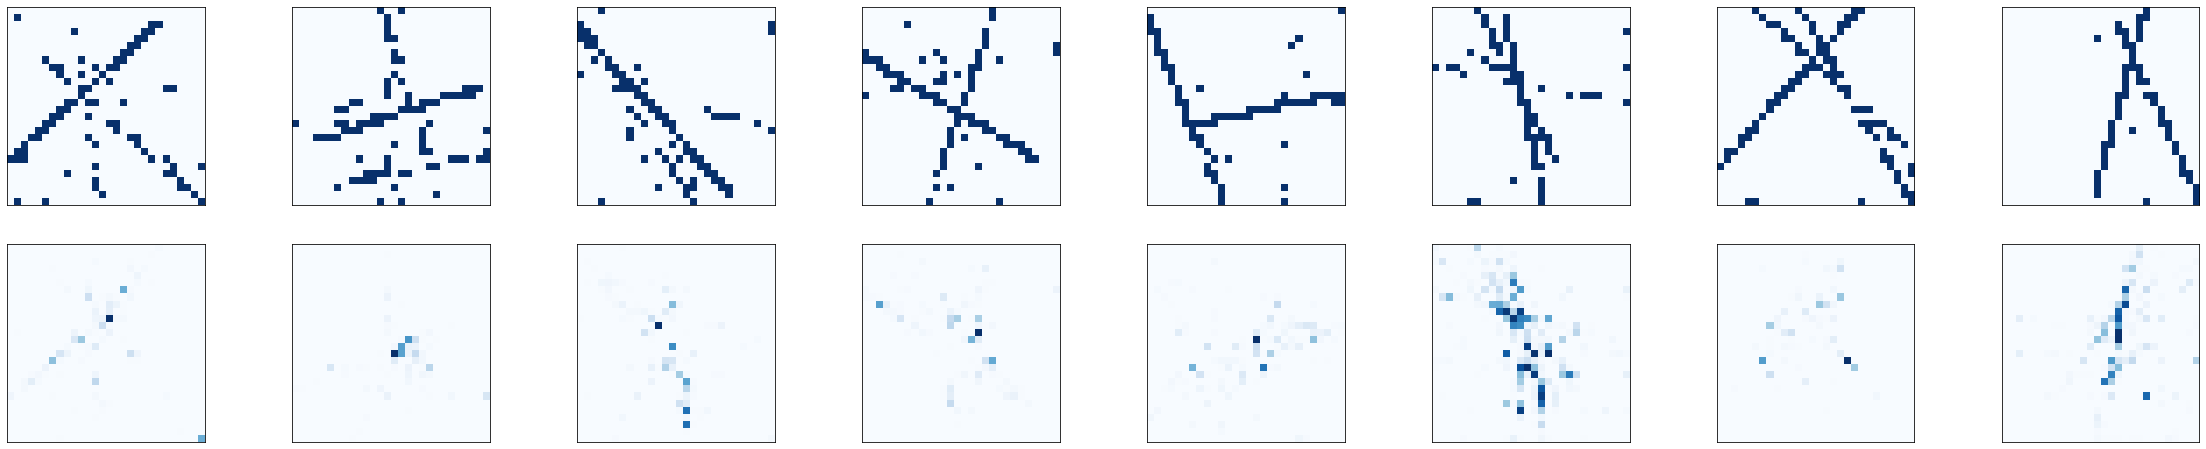

In [32]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 8  # how many digits we will display
plt.figure(figsize=(40, 8))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    #original = x_test[i].reshape(round(input_size/2), 2)
    #plt.scatter(original[:, 0], original[:, 1], cmap='Blues')
    original = x_test[i].reshape((resX, resY))
    plt.imshow(original, interpolation='nearest', cmap='Blues', extent=(0.5,np.shape(original)[0]+0.5,0.5,np.shape(original)[1]+0.5))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    #reconstruction = decoded_imgs[i].reshape(round(input_size/2), 2)
    #plt.scatter(reconstruction[:, 0], reconstruction[:, 1], cmap='Blues')
    reconstruction = decoded_imgs[i].reshape((resX, resY))
    #threshold = 0.01
    #reconstruction = reconstruction > threshold
    plt.imshow(reconstruction, interpolation='nearest', cmap='Blues', extent=(0.5,np.shape(reconstruction)[0]+0.5,0.5,np.shape(reconstruction)[1]+0.5))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

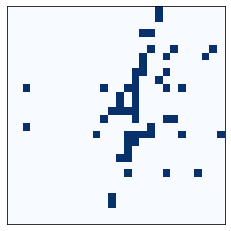

In [33]:
norm_reconstruction = reconstruction>0.05;
norm_fig = plt.imshow(norm_reconstruction, interpolation='nearest', cmap='Blues', extent=(0.5,np.shape(norm_reconstruction)[0]+0.5,0.5,np.shape(norm_reconstruction)[1]+0.5))
norm_fig.axes.get_xaxis().set_visible(False)
norm_fig.axes.get_yaxis().set_visible(False)


In [ ]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

#z_mu_base = np.random.rand(1, encoding_dim);

z_select = np.arange(encoding_dim)
np.random.shuffle(z_select)

z_mu_all = encoder.predict(x_test)
z_mu_base0 = np.reshape(z_mu_all[z_select[0]], (1, encoding_dim))
z_mu_base1 = np.reshape(z_mu_all[z_select[1]], (1, encoding_dim))
z_mu_base2 = np.reshape(z_mu_all[z_select[2]], (1, encoding_dim))
z_mu_base3 = np.reshape(z_mu_all[z_select[3]], (1, encoding_dim))

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        #z_mu = np.array([[xi, yi]]) # only for 2 dim
        # Show interpolations between four randomly chosen digits from the test set 
        z_mu = z_mu_base0 * ((xi + 3)/6)*(1-(yi + 3)/6) + z_mu_base1 * (1-(xi + 3)/6)*((yi + 3)/6)
        z_mu += z_mu_base2 * ((xi + 3)/6)*((yi + 3)/6) + z_mu_base3 * (1-(xi + 3)/6)*(1-(yi + 3)/6)
        x_mean = decoder.predict(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

In [ ]:
# The density of the layer with latent variables (not sparse!)
encoded_imgs.mean()